# ISOMAP for dimension reduction

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap
from sklearn.metrics import pairwise_distances

file_path_raw = "../../cleaned_data/joueurs_ligue1_2024_2025_clean_raw.csv"
file_path_per90 = "../../cleaned_data/joueurs_ligue1_2024_2025_clean_per90.csv"

data_raw = pd.read_csv(file_path_raw, encoding="utf-8")
data_per90 = pd.read_csv(file_path_per90, encoding="utf-8")
print(data_raw.columns)

Index(['equipe', 'player_id', 'player_name', 'player_country_code', 'age',
       'positions', 'matches_played', 'min', 'gls', 'ast',
       ...
       'second_yellow_cards', 'fls_com', 'fls_drawn', 'offside', 'pk_won',
       'pk_conceded', 'og', 'ball_recov', 'air_dual_won', 'air_dual_lost'],
      dtype='object', length=106)


### Pre-processing : remove non numeric columns, normalize as ISOMap is based on distances between points

In [69]:
def preprocessing(data):
    player_names = data['player_name']
    player_positions = data['positions']
    data_num = data.select_dtypes(include=[np.number]).dropna(axis=1, how='any')
    data_num.index = player_names
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data_num)

    removed_cols = set(data.columns) - set(data_num.columns)
    print(f"Columns removed ({len(removed_cols)}): {sorted(list(removed_cols))}")
    
    return X_scaled, data_num.columns, player_positions

X_raw, cols_raw, player_positions_raw = preprocessing(data_raw)
X_per90, cols_per90, player_positions_per90 = preprocessing(data_per90)

Columns removed (5): ['equipe', 'player_country_code', 'player_id', 'player_name', 'positions']
Columns removed (5): ['equipe', 'player_country_code', 'player_id', 'player_name', 'positions']


### ISOMap computation

In [70]:
def run_isomap(X, n_components, n_neighbors):
    iso = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    X_iso = iso.fit_transform(X)
    return X_iso, iso

X_iso_raw, iso_raw = run_isomap(X_raw, n_components=7, n_neighbors=25)
X_iso_per90, iso_per90 = run_isomap(X_per90, n_components=7, n_neighbors=25)

### Results display

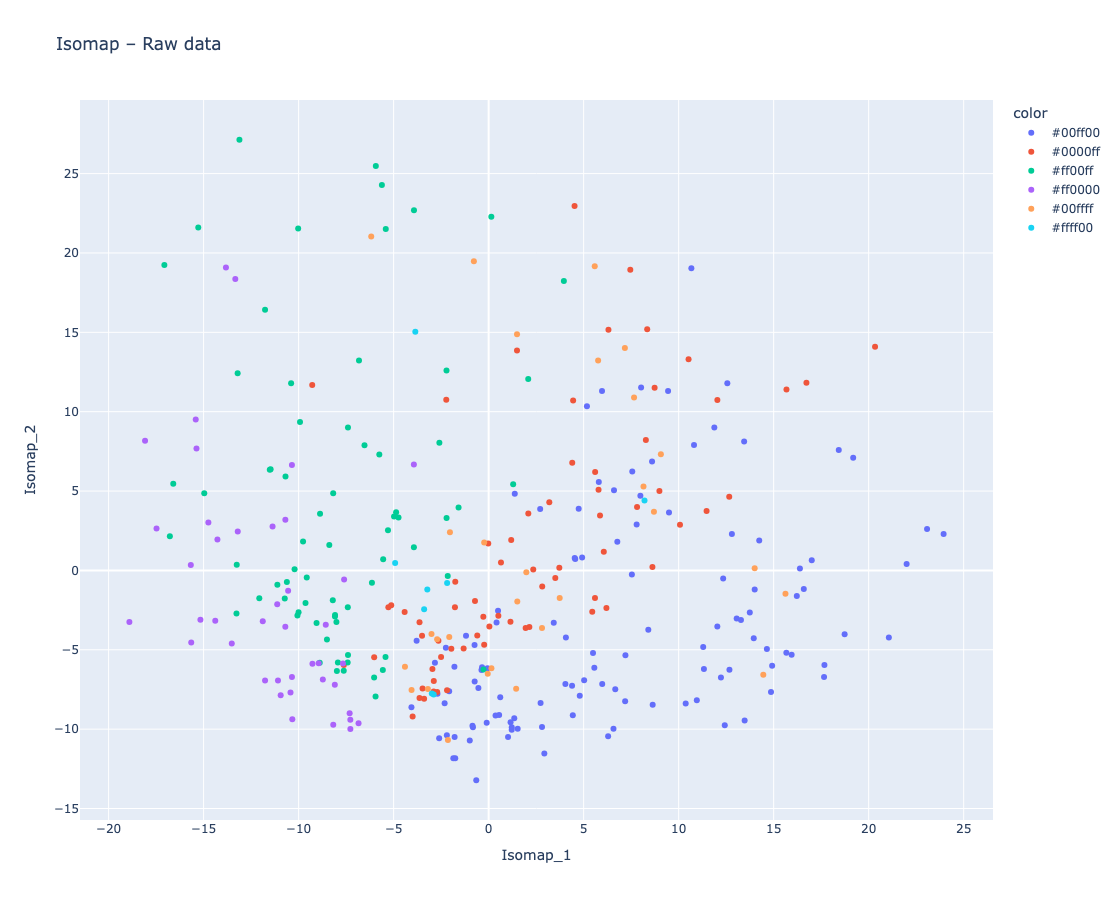

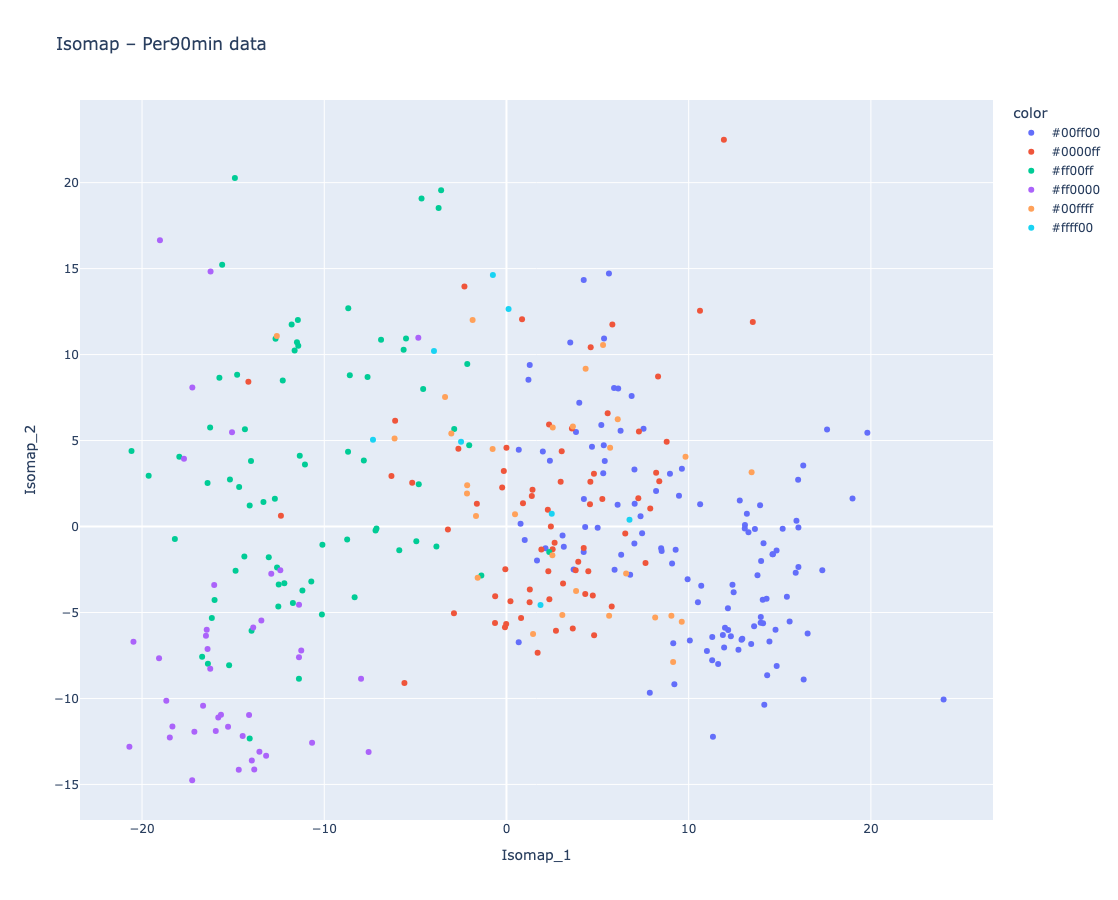

In [75]:
position_colors = {
    'FW': np.array([255, 0, 0]),    # red
    'MF': np.array([0, 0, 255]),    # blue
    'DF': np.array([0, 255, 0]),  #  yellow
}

def color_from_position(positions):
    postitions = str(positions)
    position_list = positions.split(',')
    colors = np.array([position_colors[p] for p in position_list if p in position_colors])
    avg_color = np.sum(colors, axis=0)
    return '#%02x%02x%02x' % tuple(avg_color.astype(int))

def plot_isomap_interactive(X_iso, player_positions, data_num, title):
    df_plot = pd.DataFrame({
        'Isomap_1': X_iso[:, 0],
        'Isomap_2': X_iso[:, 1],
        'player_name': data_num.index,
        'color' : player_positions.apply(color_from_position)
    })
    
    fig = px.scatter(
        df_plot,
        x='Isomap_1', y='Isomap_2',
        hover_name='player_name',
        color='color',
        title=title,
        height=900, width=1100 
    )
    fig.show()

plot_isomap_interactive(X_iso_raw, player_positions_raw ,data_raw.set_index("player_name"), "Isomap – Raw data")
plot_isomap_interactive(X_iso_per90, player_positions_per90 ,data_per90.set_index("player_name"), "Isomap – Per90min data")

### Results Analysis

=== Raw data ===
Shape embedding: (333, 15)
Stress: 0.8915
Geodesic dist btw players (mean/std) : 22.83842231567379 / 9.495643215809338
relative variance (Isomap comps): [0.32691858 0.26809897 0.0883696  0.04971883 0.04169238 0.03943664
 0.02971671 0.02751668 0.02399752 0.02006638 0.01894426 0.01743023
 0.01697963 0.01631295 0.01480063]


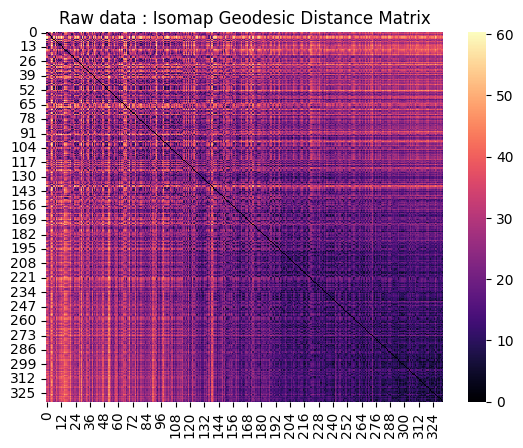


=== Data per 90 min ===
Shape embedding: (333, 15)
Stress: 1.0501
Geodesic dist btw players (mean/std) : 25.582083089081515 / 9.555456105689888
relative variance (Isomap comps): [0.43414814 0.16695801 0.06941961 0.06152728 0.0462778  0.0404641
 0.02959422 0.02585396 0.02141902 0.02030952 0.02013041 0.01790907
 0.01625864 0.01513002 0.0146002 ]


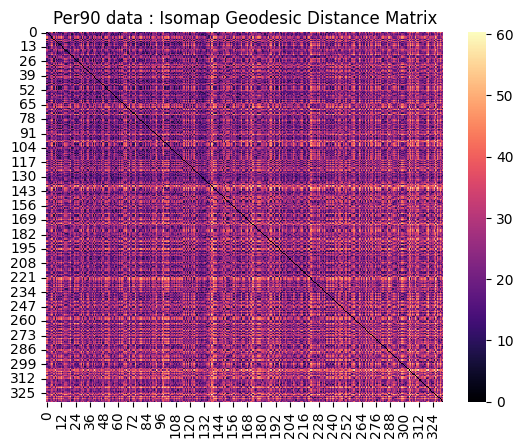


=== Comparisons between both datasets : ===
Similarity of 5 closest neighbors btw both datasets (in %) : 0.3771771771771772


In [56]:
def extractMetrics(iso, data, data_iso) : 
    kernel_matrix = iso.dist_matrix_  #geodesic distance btw players
    shape = iso.embedding_.shape      #nb players / nb dim

    # pairwise distance
    D_high = pairwise_distances(data)
    D_low = pairwise_distances(data_iso)
    stress = np.sqrt(np.sum((D_high - D_low)**2) / np.sum(D_high**2))   #How much did we change the geodesic distances btw players ? in [0;1]

    # relative Variance per dimension :
    variances = np.var(data_iso, axis=0)
    explained_like_ratio = variances / np.sum(variances)

    return kernel_matrix, shape, stress, explained_like_ratio

def compare_neighbors(kernel1, kernel2, k=5):
    idx1 = np.argsort(kernel1, axis=1)[:, 1:k+1]
    idx2 = np.argsort(kernel2, axis=1)[:, 1:k+1]
    return np.mean([len(set(i1).intersection(i2)) / k for i1, i2 in zip(idx1, idx2)])

kernel_raw, shape_raw, stress_raw, var_ratio_raw = extractMetrics(iso_raw, X_raw, X_iso_raw)
kernel_per90, shape_per90, stress_per90, var_ratio_per90 = extractMetrics(iso_per90, X_per90, X_iso_per90)
neighbor_stability = compare_neighbors(kernel_raw, kernel_per90)

print("=== Raw data ===")
print(f"Shape embedding: {shape_raw}")
print(f"Stress: {stress_raw:.4f}")
print(f"Geodesic dist btw players (mean/std) : {np.mean(kernel_raw)} / {np.std(kernel_raw)}")
print(f"relative variance (Isomap comps): {var_ratio_raw}")
# Geodesic distances analysis
sns.heatmap(kernel_raw, cmap="magma")
plt.title("Raw data : Isomap Geodesic Distance Matrix")
plt.show()

print("\n=== Data per 90 min ===")
print(f"Shape embedding: {shape_per90}")
print(f"Stress: {stress_per90:.4f}")
print(f"Geodesic dist btw players (mean/std) : {np.mean(kernel_per90)} / {np.std(kernel_per90)}")
print(f"relative variance (Isomap comps): {var_ratio_per90}")
# Geodesic distances analysis
sns.heatmap(kernel_per90, cmap="magma")
plt.title("Per90 data : Isomap Geodesic Distance Matrix")
plt.show()

print("\n=== Comparisons between both datasets : ===")
print(f"Similarity of 5 closest neighbors btw both datasets (in %) : {neighbor_stability}")

In [ ]:
### GridSearch analysis of hyperparameters of ISOMap

In [57]:
def grid_search_isomap(data_raw, data_per90, n_neighbors_list, n_components_list):
    results_raw = []
    results_per90 = []
    results_stability = []
    

    for n_neighbors in n_neighbors_list:
        for n_components in n_components_list:
            iso_raw = Isomap(n_neighbors=n_neighbors, n_components=n_components)
            iso_per90 = Isomap(n_neighbors=n_neighbors, n_components=n_components)
            data_iso_raw = iso_raw.fit_transform(data_raw)
            data_iso_per90 = iso_per90.fit_transform(data_per90)
            kernel_raw, _ , stress_raw, var_ratio_raw = extractMetrics(iso_raw, data_raw, data_iso_raw)
            min_var_raw = np.min(var_ratio_raw)
            kernel_per90, _ , stress_per90, var_ratio_per90 = extractMetrics(iso_per90, data_per90, data_iso_per90)
            min_var_per90 = np.min(var_ratio_per90)
            
            results_raw.append({
                "n_neighbors": n_neighbors,
                "n_components": n_components,
                "stress": stress_raw,
                "min_var": min_var_raw,
                "geodesic_dist" : f"{np.mean(kernel_raw) / np.std(kernel_raw)}"
            })
            results_per90.append({
                "n_neighbors": n_neighbors,
                "n_components": n_components,
                "stress": stress_per90,
                "min_var": min_var_per90,
                "geodesic_dist" : f"{np.mean(kernel_per90) / np.std(kernel_per90)}"
            })

            results_stability.append({
                "n_neighbors": n_neighbors,
                "n_components": n_components,
                "neighbours_stability" : compare_neighbors(kernel_raw, kernel_per90)
             })
    
    df_raw = pd.DataFrame(results_raw)
    df_per90 = pd.DataFrame(results_per90)
    df_stability = pd.DataFrame(results_stability)
    return df_raw, df_per90, df_stability

neighbors_grid = [10, 15, 20, 25, 30]
components_grid = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# --- Grid search sur les datasets ---
results_raw, results_per90, results_stability = grid_search_isomap(X_raw, X_per90, neighbors_grid, components_grid)

# --- Affichage des résultats ---
print("=== Raw data ===")
print("\nStress for raw data:")
print(results_raw.pivot(index='n_neighbors', columns='n_components', values='stress'))

print("\nMin variance for last column of raw data:")
print(results_raw.pivot(index='n_neighbors', columns='n_components', values='min_var'))

print("\nGeodesic_dist for raw data:")
print(results_raw.pivot(index='n_neighbors', values='geodesic_dist'))

print("\n=== Per90 data ===")
print("\nStress for per90 data:")
print(results_per90.pivot(index='n_neighbors', columns='n_components', values='stress'))

print("\nMin variance for last column of per90 data:")
print(results_per90.pivot(index='n_neighbors', columns='n_components', values='min_var'))

print("\nGeodesic_dist for per90 data:")
print(results_per90.pivot(index='n_neighbors', values='geodesic_dist'))

print("\nSimilarity of 5 closest neighbors btw both datasets (in %):")
print(results_stability.pivot(index='n_neighbors', columns='n_components', values='neighbours_stability'))

=== Raw data ===

Stress for raw data:
n_components        2         3         4         5         6         7   \
n_neighbors                                                                
10            0.538227  0.604881  0.648481  0.684672  0.721475  0.749441   
15            0.442266  0.482167  0.514671  0.546864  0.573404  0.597815   
20            0.391343  0.419899  0.448819  0.473929  0.496731  0.517782   
25            0.333858  0.351838  0.372565  0.396431  0.418333  0.438994   
30            0.302888  0.313805  0.332679  0.354234  0.372675  0.391548   

n_components        8         9         10  
n_neighbors                                 
10            0.774530  0.796329  0.814403  
15            0.618382  0.638328  0.655416  
20            0.536401  0.554194  0.569502  
25            0.456078  0.472774  0.488545  
30            0.408417  0.424709  0.439486  

Min variance for last column of raw data:
n_components        2         3         4         5         6         